**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
- [S√©lection de 3 classes, √©chantillonnage, encodage, jeux de donn√©es](#toc2_)    
  - [√âchantillonnage et encodage](#toc2_1_)    
  - [Configuration commune](#toc2_2_)    
  - [Jeux de donn√©es](#toc2_3_)    
- [Transfer Learning](#toc3_)    
  - [Fine-tuning total](#toc3_1_)    
  - [Extraction des features](#toc3_2_)    
  - [Fine-tuning partiel](#toc3_3_)    
- [Strat√©gie](#toc4_)    
- [VGG16](#toc5_)    
- [MobileNetV2](#toc6_)    
- [EfficientNet](#toc7_)    
- [Preuve avec 10 classes](#toc8_)    
  - [√âchantillonnage et encodage](#toc8_1_)    
  - [Configuration](#toc8_2_)    
  - [Jeux de donn√©es](#toc8_3_)    
  - [R√©-entra√Ænement pour 10 classes](#toc8_4_)    
- [Conclusion](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import yaml
import shutil
import logging

# DS, ML & DL
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.applications import EfficientNetB0, MobileNetV2
from keras.utils import image_dataset_from_directory
from keras.layers import Flatten, Dense
from keras.optimizers import AdamW

# images & data viz
import matplotlib.pyplot as plt

# home made functions from src folder
from src.get_data import get_tar_and_extract
from src.get_data import create_img_db
from src.models import eval_pretrained_model, ConditionalAugmentation

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-07-31 15:48:22.147500: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 15:48:22.191068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 15:48:23.040720: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Configuration

In [2]:
# environment config
load_dotenv()
IMG_URL = os.getenv("IMG_URL")
ANNOT_URL = os.getenv("ANNOT_URL")

# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

CLASSES_3 = cfg["models"]["classes_3"]
CLASSES_10 = cfg["models"]["classes_10"]
DATA_DIR = cfg["data"]["local_path"]
IMG_DIR = os.path.join(DATA_DIR, cfg["data"]["img_dir"])
ANNOT_DIR = os.path.join(DATA_DIR, cfg["data"]["annot_dir"])
IMG_DB_URI = os.path.join(DATA_DIR, cfg["data"]["img_db_uri"])
TRAIN_DIR = os.path.join(DATA_DIR, cfg["data"]["train_dir"])
TEST_DIR = os.path.join(DATA_DIR, cfg["data"]["test_dir"])
CHKPT_DIR = os.path.join(DATA_DIR, cfg["data"]["checkpoint_dir"])
APP_DIR = os.path.join(DATA_DIR, cfg["data"]["app_dir"])
TRAIN_DIR_10 = TRAIN_DIR + "_10"
TEST_DIR_10 = TEST_DIR + "_10"
LOG_DIR = cfg["log"]["log_dir"]

Images et annotations, cr√©ation de la BDD

In [3]:
if os.path.exists(IMG_DB_URI):
    img_df = pd.read_csv(IMG_DB_URI, index_col=0)
else:
    # download, extract and store data
    print("‚öôÔ∏è Downloading images...")
    get_tar_and_extract(IMG_URL, DATA_DIR)
    print("‚öôÔ∏è Downloading annotations...")
    get_tar_and_extract(ANNOT_URL, DATA_DIR)
    print("‚öôÔ∏è Creating database...")

    # create database
    img_df = create_img_db(IMG_DIR, ANNOT_DIR, IMG_DB_URI)

# <a id='toc2_'></a>[S√©lection de 3 classes, √©chantillonnage, encodage, jeux de donn√©es](#toc0_)

Conservation des classes vues dans le notebook pr√©c√©dent :
- Carlin (*pug*),
- Husky de Sib√©rie (*Siberian_husky*),
- Barzo√Ø (*borzoi*)

171.5 images per class, 443.0 avg width, 386.0 avg height


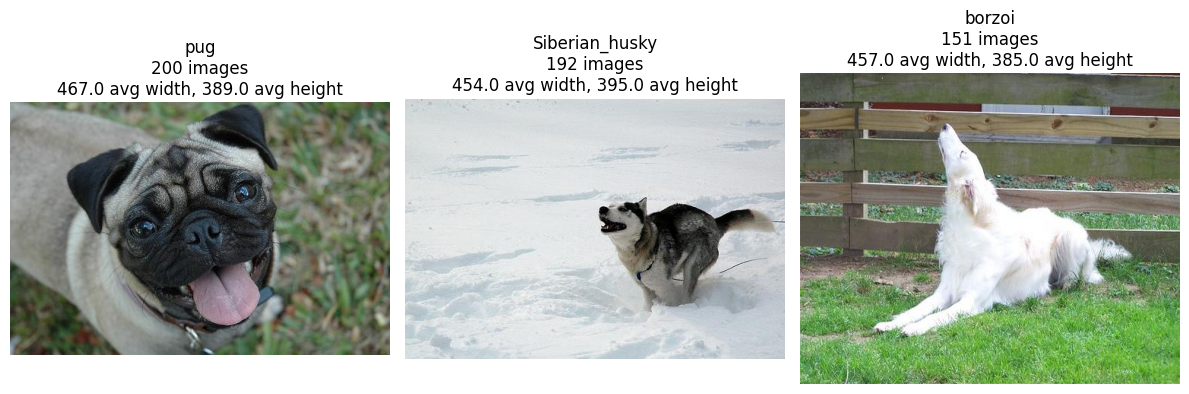

original shape (20580, 10) -> selected (543, 10)


In [4]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

for i, c in enumerate(CLASSES_3):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

img_ds = img_df.loc[img_df["class_label"].isin(CLASSES_3)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

## <a id='toc2_1_'></a>[√âchantillonnage et encodage](#toc0_)

In [5]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# create samples directories
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(CHKPT_DIR):
    os.makedirs(CHKPT_DIR)


def copy_images(X, dir) -> None:
    i = 0
    for src_uri in X:
        img_name = src_uri.split("/")[-1]
        img_class = src_uri.split("/")[-2].split("-")[-1]
        dest_uri = os.path.join(dir, img_class, img_name)
        # create folder if needed
        if not os.path.exists(os.path.join(dir, img_class)):
            os.makedirs(os.path.join(dir, img_class))
        # copy image
        if not os.path.exists(dest_uri):
            shutil.copy2(src_uri, dest_uri)
        # count processed images
        i += 1
    print(f"{i} images processed")


copy_images(X_train, TRAIN_DIR)
copy_images(X_test, TEST_DIR)

488 images processed
55 images processed


## <a id='toc2_2_'></a>[Configuration commune](#toc0_)

In [6]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

Cette configuration permet de compiler des mod√®les, qui seront tous entra√Æn√©s de la m√™me mani√®re :

``` python
model_trained, history = eval_pretrained_model(
    model=insert_model_here,
    train_ds=insert_train_ds_here,
    val_ds=insert_val_ds_here,
    test_ds=insert_test_ds_here,
    LOG_DIR=LOG_DIR,
    CHKPT_DIR=CHKPT_DIR,
    model_name=model_name,
    input_size=input_size,
    batch_size=batch_size,
    n_epochs=n_epochs,
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
```

## <a id='toc2_3_'></a>[Jeux de donn√©es](#toc0_)

In [7]:
print("Train / val datasets:")
train_ds, val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train / val datasets:
Found 488 files belonging to 3 classes.
Using 391 files for training.
Using 97 files for validation.

Test dataset:
Found 55 files belonging to 3 classes.


# <a id='toc3_'></a>[Transfer Learning](#toc0_)

Le *transfer learning* permet :
- l'√©conomie de ressources et de temps
- le r√©entra√Ænement des seules couches sup√©rieures
- d'**√©viter le surentra√Ænement** puisque lors d'un apprentissage de z√©ro, le **nombre de param√®tres √† apprendre √©tant largement sup√©rieur au nombre d'images**

Le choix du mod√®le se fait selon :
- le jeu de donn√©es d'entr√©e
- la similarit√© avec notre probl√©matique
- la strat√©gie adopt√©e

## <a id='toc3_1_'></a>[Fine-tuning total](#toc0_)

**Lorsque la nouvelle collection d'images est grande**, on peut se permettre d'entra√Æner tout le r√©seau sans courir le risque de sur-entra√Ænement et comme les param√®tres de toutes les couches (sauf de la derni√®re) sont initialement ceux du r√©seau pr√©-entra√Æn√©, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait √©t√© al√©atoire.

On **remplace la derni√®re couche** (dense) du r√©seau pr√©-entra√Æn√© par un **classifieur adapt√© au nouveau probl√®me** et **initialis√© de mani√®re al√©atoire** ‚Üí toutes les couches sont ensuite entra√Æn√©es sur les nouvelles images.

> ‚û°Ô∏è cette strat√©gie n'est donc pas applicable ici car la collection d'images est petite (150 √† 200 images par classe)

## <a id='toc3_2_'></a>[Extraction des features](#toc0_)

**Lorsque la nouvelle collection d'images est petite** entra√Æner un r√©seau complet m√®nerait √† un sur-entra√Ænement.  
**Si elle est en plus similaire aux images de pr√©-entra√Ænement**, on peut **se servir des features du r√©seau pr√©-entra√Æn√© pour repr√©senter les images du nouveau probl√®me** car les nouvelles images peuvent alors √™tre repr√©sent√©es par les m√™mes features.

Pour cela, on **retire la derni√®re couche dense** et on **fixe tous les autres param√®tres** ‚Üí le r√©seau va calculer la repr√©sentation de chaque image √† partir des features d√©j√† apprises lors du pr√©-entra√Ænement.  
On entra√Æne alors un **classifieur, initialis√© al√©atoirement**, sur ces repr√©sentations pour r√©soudre le nouveau probl√®me.

> ‚û°Ô∏è cette strat√©gie pourrait √™tre applicable ici √† condition d'avoir un mod√®le pr√©-entra√Æn√© sur des images assez similaires

## <a id='toc3_3_'></a>[Fine-tuning partiel](#toc0_)

Cette strat√©gie est utilis√©e **lorsque la nouvelle collection d'images est petite mais tr√®s diff√©rente** des images du pr√©-entra√Ænement :
- comme il y a peu d'images d'entra√Ænement, la strat√©gie de fine-tuning total n'est pas envisageable √† cause du risque d'overfitting
- les nouvelles images ont tr√®s peu de points communs avec les anciennes : utiliser les features du r√©seau pr√©-entra√Æn√© pour les repr√©senter n'est pas une bonne id√©√©

Il s'agit **compromis** m√©langeant les strat√©gies pr√©c√©dentes : on **remplace la derni√®re couche dense par le nouveau classifieur initialis√© al√©atoirement**, et on **fixe les param√®tres de certaines couches** du r√©seau pr√©-entra√Æn√©.  
Ainsi, **en plus du classifieur**, on entra√Æne sur les nouvelles images les **couches non-fix√©es**, qui correspondent en g√©n√©ral aux plus hautes couches du r√©seau.

> ‚û°Ô∏è cette strat√©gie pourrait √™tre applicable, si par exemple on dispose d'un mod√®le performant mais n'ayant jamais vu d'images de chien

# <a id='toc4_'></a>[Strat√©gie](#toc0_)

Afin d'√©conomiser des ressources, les mod√®les choisis sont des **mod√®les entra√Æn√©s eux aussi sur ImageNet**.  
Pour rappel, le Stanford Dogs Dataset est issue du jeu de donn√©es ImageNet, ces mod√®les **ne n√©cessitent qu'une extraction de features**.

> #### ‚ö†Ô∏è Fuite de donn√©es ?
> Effectivement, il y a une fuite de donn√©es car **les mod√®les entra√Æn√©s sur ImageNet ont d√©j√† vu les images issues du Stanford Dogs Dataset**.  
> Cependant :
> - ces mod√®les **n'ont pas √©t√© entra√Æn√©s pour y d√©tecter pr√©cis√©ment les races de chiens** mais plut√¥t les objets ou sujets repr√©sent√©s, ce qui **enl√®ve la fuite de donn√©es au niveau des couches sup√©rieures**
> - ImageNet est compos√© de 1 281 167 images d'entra√Ænement et 50k images de validation (+ 100k images de test), ce qui correspond √† **1 331 167 images vues par le mod√®le**
> - les images utilis√©es dans le notebook sont tr√®s peu nombreuses sur le jeu de donn√©es total :
>   - pour le probl√®me √† 3 classes, **488 images** sont utilis√©es √† l'entra√Ænement, soit **< 0.0004%** des images vues par les mod√®les durant leur entra√Ænement
>   - pour le probl√®me √† 10 classes, **1 578 images** sont utilis√©es √† l'entra√Ænement, soit **< 0.0012%**
> - enfin, une **augmentation des donn√©es de 40% est effectu√©e sur les images pour l'entra√Ænement**, ce qui diminue encore la part de fuite de donn√©es
> üëâ Il est possible d'en d√©duire que la fuite de donn√©es, si elle existe en principe, a une **incidence n√©gligeable sur l'apprentissage des mod√®les et les r√©sultats inh√©rents**.

# <a id='toc5_'></a>[VGG16](#toc0_)

Cet ancien mod√®le de 2014 √† l'architecture simple et r√©guli√®re a permis √† beaucoup de mieux comprendre les r√©seaux convolutionnels et est toujours un excellent point d'approche.  

Son innovation a r√©sid√© √† la fois dans la grande profondeur de ses couches et dans la petite taille des filtres (3x3), permettant √† l'√©poque de r√©duire le nombre de param√®tres et de mieux pr√©server les caract√©ristiques spatiales essentielles.

<img src="https://user.oc-static.com/upload/2018/03/14/15209908694697_vgg-16-3dc.png">

Il est con√ßu pour d√©tecter 1000 classes : lors du changement de classifieur on devra donc utiliser une **couche dense √† 3 sorties** √† la place de 1000.

- [Documentation Keras ici](https://keras.io/api/applications/vgg/#vgg16-function)

In [8]:
model_name = "vgg16_3c"

# load pre-trained VGG-16 without top layers
model = VGG16(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
vgg16_3c = Model(inputs=inputs, outputs=predictions)
# display model summary
vgg16_3c.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_1 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conditional_augmentation        ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îÇ (ConditionalAugmentation)       ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ vgg16 (Functional)              ‚îÇ (None, 7, 7, 512)      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 25088)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 3)              ‚îÇ        75,267 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

<img src="outputs/7_transfer/vgg16_3c_cmtx.png" height="400px">
<img src="outputs/7_transfer/vgg16_3c_metric.png" height="400px">
<img src="outputs/7_transfer/vgg16_3c_loss.png" height="400px">

‚û°Ô∏è Commentaires
- la pr√©cision est excellente
- le temps d'entra√Ænement est relativement long : le mod√®le a atteint son point haut √† la 13¬∞ √©poque
- l'apprentissage est tr√®s lent : 93" / √©poque pour apprendre sur 75k param√®tres

# <a id='toc6_'></a>[MobileNetV2](#toc0_)

Apr√®s un tel entra√Ænement, il est int√©ressant de tester un mod√®le plus l√©ger et moins gourmand en ressources.

MobileNetV2 est justement d√©sign√© pour les architectures mobiles, avec des ressources donc bien plus limit√©es.  
Il s'agit d'une √©volution de MobileNet, qui exploite des convolutions en profondeur s√©parables pour r√©duire la complexit√© computationnelle.  

L'innovation de MobileNetV2 est l'utilisation de **blocs MBConv** (*Mobile Inverted Bottleneck Convolution*) qui sont particuli√®rement efficaces pour r√©duire le nombre de param√®tres tout en maintenant de bonnes performances, de goulots d'√©tranglement lin√©aires et de couches d'expansion.

- [Papier original r√©vis√© en mars 2019](https://arxiv.org/pdf/1801.04381v4)

<figure>
  <img src="outputs/mobilenetv2_2.png" height="360">
  <img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.37.14_PM.png" height="360">
  <figcaption>Principes de convolutions s√©parables, de goulots lin√©aires et de couches d'expansion</figcaption>
</figure>

In [9]:
model_name = "MobileNetV2"

# load pre-trained model without top layers
model = MobileNetV2(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
mobnetv2 = Model(inputs=inputs, outputs=predictions)
# display model summary
mobnetv2.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_3 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conditional_augmentation_1      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îÇ (ConditionalAugmentation)       ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ mobilenetv2_1.00_224            ‚îÇ (None, 7, 7, 1280)     ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)             ‚îÇ (None, 62720)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 3)              ‚îÇ       188,163 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,446,147 (9.33 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<img src="outputs/7_transfer/MobileNetV2_cmtx.png" height="400px">
<img src="outputs/7_transfer/MobileNetV2_metric.png" height="400px">
<img src="outputs/7_transfer/MobileNetV2_loss.png" height="400px">

‚û°Ô∏è Commentaires
- la pr√©cision du mod√®le n'est pas bonne
- l'apprentissage est par contre tr√®s rapide car il a appris sur 188k param√®tres √† 11" / √©poque, soit plus de 20 fois plus rapide que VGG16

# <a id='toc7_'></a>[EfficientNet](#toc0_)

Dat√© de 2019, EfficientNet est issu du constat qu'une **mise √† l'√©chelle compos√©e** (*Compound Scaling*) c'est-√†-dire uniforme du r√©seau convolutionnel est plus efficace que les pratiques qui consistaient √† augmenter soit la **profondeur**, soit la **largeur** soit la **r√©solution**.  
EfficientNet b√©n√©ficie ainsi de mod√®les plus √©quilibr√©s et efficaces en terme de ressources computationnelles / nombre et poids des param√®tres / pr√©cision.

Par ailleurs, cette famille de mod√®les permet une grande mise √† l'√©chelle avec une base initiale d√©j√† tr√®s performante.  
Il est int√©ressant de souligner que les blocs MBConv de MobileNet sont utilis√©s aussi dans ses architecture.

- [Papier original r√©vis√© sept. 2020](https://arxiv.org/pdf/1905.11946)

<img src="https://www.researchgate.net/publication/351057828/figure/fig2/AS:1022512410394634@1620797364891/The-structure-of-an-EfficientNetB0-model-with-the-internal-structure-of-MBConv1-and.png">

EfficientNet existe en plusieurs versions, not√©es de **B0 √† B7**, avec des mod√®les de plus en plus larges et profonds.  
Vu le peu de ressources de la probl√©matique, **le mod√®le le plus l√©ger sera d'abord test√©** et seulement si ses performances sont trop peu satisfaisantes, les mod√®les plus complexes seront abord√©s.

In [10]:
model_name = "EfficientNetB0"

# load pre-trained model without top layers
model = EfficientNetB0(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation="softmax")(x)
# define new model
effnetB0 = Model(inputs=inputs, outputs=predictions)
# display model summary
effnetB0.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_5 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conditional_augmentation_2      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îÇ (ConditionalAugmentation)       ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ efficientnetb0 (Functional)     ‚îÇ (None, 7, 7, 1280)     ‚îÇ     4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)             ‚îÇ (None, 62720)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 3)              ‚îÇ       188,163 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,237,734 (16.17 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

<img src="outputs/7_transfer/EfficientNetB0_cmtx.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_metric.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_loss.png" height="400px">

‚û°Ô∏è Commentaires
- sa pr√©cision est presque parfaite
- il a effectu√© son apprentissage en seulement 5 √©poques
- ce mod√®le a le plus court temps d'apprentissage avec moins de 18" / √©poque pour 188k param√®tres (soit presque 13 fois plus rapide que VGG16)
- les param√®tres sont 3 fois plus l√©gers que le mod√®le VGG
- pas besoin de tester les mod√®les EfficientNet plus complexes

# <a id='toc8_'></a>[Preuve avec 10 classes](#toc0_)

Pour un travail sur davantages de classes, le nombre d'√©poques maximales de la fonction early stopping a √©t√© r√©hauss√©.

171.5 images per class, 443.0 avg width, 386.0 avg height


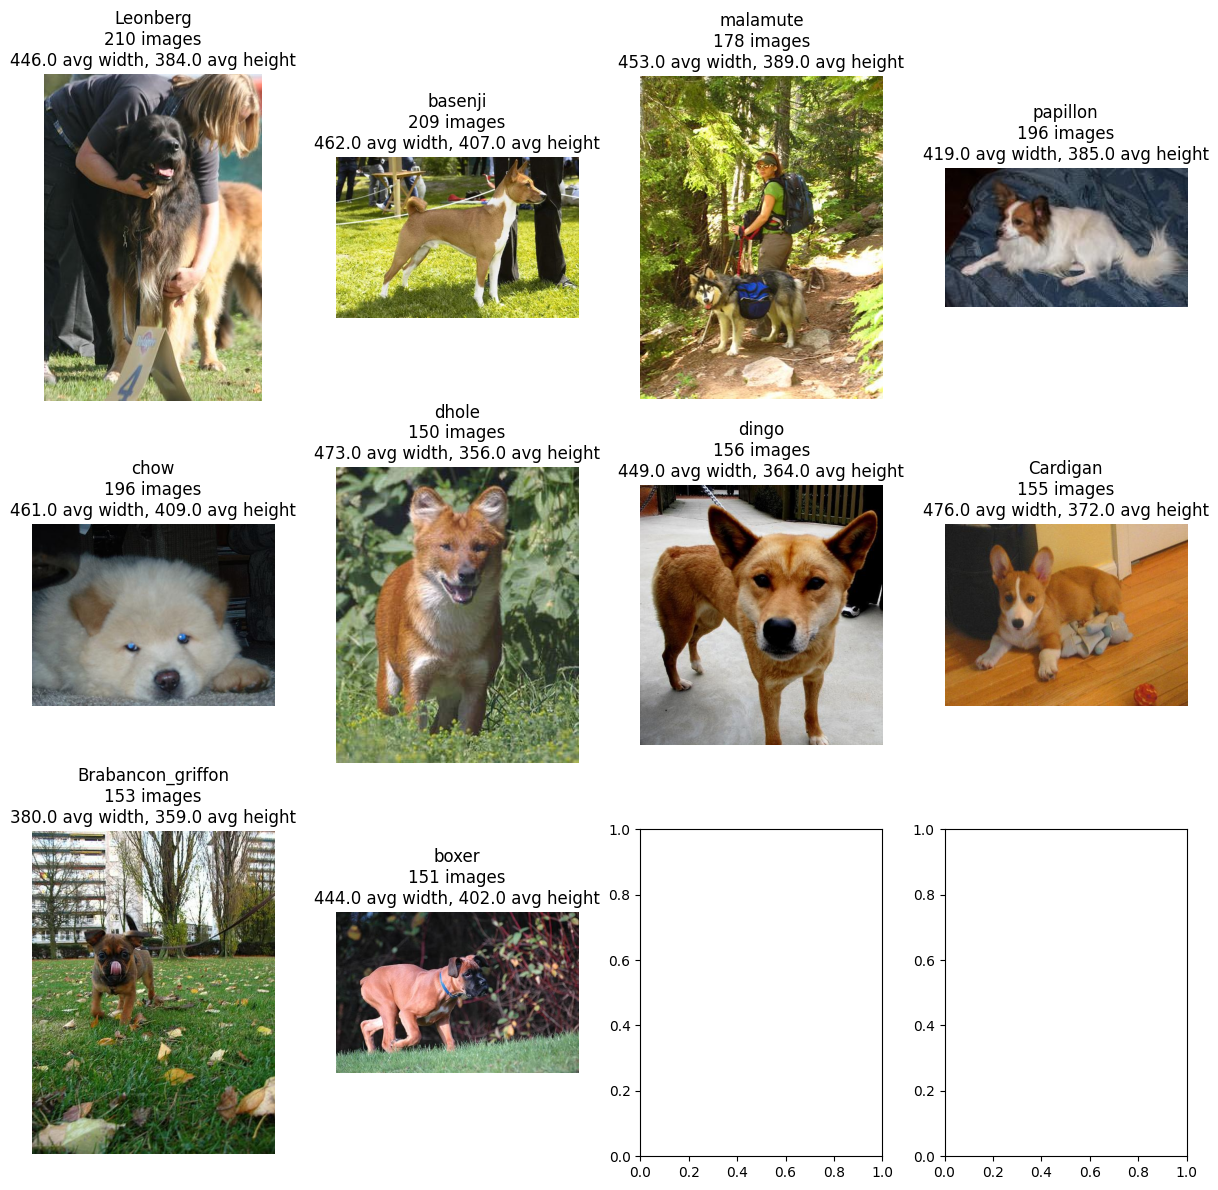

original shape (20580, 10) -> selected (1754, 10)


In [11]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

for i, c in enumerate(CLASSES_10):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    row = i // cols
    col = i % cols
    axs[row][col].imshow(img)
    axs[row][col].axis("off")
    axs[row][col].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

img_ds = img_df.loc[img_df["class_label"].isin(CLASSES_10)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

## <a id='toc8_1_'></a>[√âchantillonnage et encodage](#toc0_)

In [12]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# train / test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
# use some images in app folder
X_test, X_app, y_test, y_app = train_test_split(
    X_temp, y_temp, test_size=0.1, stratify=y_temp, random_state=42
)

# create samples directories
if not os.path.exists(TRAIN_DIR_10):
    os.makedirs(TRAIN_DIR_10)
if not os.path.exists(TEST_DIR_10):
    os.makedirs(TEST_DIR_10)
if not os.path.exists(APP_DIR):
    os.makedirs(APP_DIR)

print("Train set: ")
copy_images(X_train, TRAIN_DIR_10)
print("Test set: ")
copy_images(X_test, TEST_DIR_10)
print("App set: ")
copy_images(X_app, APP_DIR)

Train set: 
1578 images processed
Test set: 
158 images processed
App set: 
18 images processed


## <a id='toc8_2_'></a>[Configuration](#toc0_)

In [13]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

## <a id='toc8_3_'></a>[Jeux de donn√©es](#toc0_)

In [14]:
print("Train / val datasets:")
train_ds_10, val_ds_10 = image_dataset_from_directory(
    TRAIN_DIR_10,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds_10 = image_dataset_from_directory(
    TEST_DIR_10,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train / val datasets:
Found 1578 files belonging to 10 classes.
Using 1263 files for training.
Using 315 files for validation.

Test dataset:
Found 158 files belonging to 10 classes.


## <a id='toc8_4_'></a>[R√©-entra√Ænement pour 10 classes](#toc0_)

In [15]:
model_name = "EfficientNetB0_10"

# load pre-trained model without top layers
model = EfficientNetB0(
    weights="imagenet",  # pre-trained weights
    include_top=False,  # no dense layer
    input_shape=(input_size[0], input_size[1], 3),  # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
    layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(10, activation="softmax")(x)
# define new model
effnetB0_10 = Model(inputs=inputs, outputs=predictions)
# display model summary
effnetB0_10.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_7 (InputLayer)      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conditional_augmentation_3      ‚îÇ (None, 224, 224, 3)    ‚îÇ             0 ‚îÇ
‚îÇ (ConditionalAugmentation)       ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ efficientnetb0 (Functional)     ‚îÇ (None, 7, 7, 1280)     ‚îÇ     4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten)             ‚îÇ (None, 62720)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 10)             ‚îÇ       627,210 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,676,781 (17.84 MB)

 Trainable params: 627,210 (2.39 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

<img src="outputs/7_transfer/EfficientNetB0_10_cmtx.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_10_metric.png" height="400px">
<img src="outputs/7_transfer/EfficientNetB0_10_loss.png" height="400px">

‚û°Ô∏è Commentaires
- le temps d'entra√Ænement est tr√®s court par rapport au nombre de classes √† apprendre
- ce mod√®le est tr√®s performant, avec des erreurs peu nombreuses et localis√©es majoritairement sur une classe
- un tr√®s bon compromis ressources / performances

# <a id='toc9_'></a>[Conclusion](#toc0_)

Les diff√©rents mod√®les test√©s montrent bien leurs diff√©rences lors de l'entra√Ænement, m√™me avec peu de classes √† apprendre et des hyperparam√®tres similaires.

**EfficientNet a montr√© d'excellentes capacit√©s**, m√™me dans sa version minimale, tant pour 3 que pour 10 classes et sa relative l√©g√®ret√© (< 18Mo de param√®tres) en fait un mod√®le de choix √† impl√©menter dans l'application m√©tier r√©pondant √† la probl√©matique de cet exercice.